# Investigating bot statistics

## Download or load data

Here download a new dataset if desired or load an already downloaded one

### Downloading data:

In [33]:
# We don't want to exceed the max limit of bot checks
# So give it here and stop running if it is reached
botometer_max_limit = 1000
bot_check_count = 0

In [3]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from tqdm import tqdm

In [4]:
# Just pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/var/folders/hx/0dxb0wn51wx5pscstjkwf2gc000qqf/T/ipykernel_62402/1119663756.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [16]:
# A function to create a pair of lists for days to search
def create_date_lists(since_initial, until_final):
    """
    Creates a a pair of lists for since and until dates of the form
    since_list = ['2022-02-24', '2022-02-25', '2022-02-26']
    until_list = ['2022-02-25', '2022-02-26', '2022-02-27']
    """
    import datetime

    diff = datetime.datetime.strptime(until_final, "%Y-%m-%d") - datetime.datetime.strptime(since_initial, "%Y-%m-%d")
    diff = diff.days

    since_initial_datetime = datetime.datetime.strptime(since_initial, "%Y-%m-%d")
    until_initial_datetime = since_initial_datetime + datetime.timedelta(days=1)
    until_initial_datetime = datetime.datetime.strftime(until_initial_datetime, "%Y-%m-%d")

    diff = datetime.datetime.strptime(until_final, "%Y-%m-%d") - datetime.datetime.strptime(since_initial, "%Y-%m-%d")
    diff = diff.days

    since_list = []
    until_list = []
    for day in range(diff):
        since_plus_day = since_initial_datetime + datetime.timedelta(days=day)
        since_plus_day = datetime.datetime.strftime(since_plus_day, "%Y-%m-%d")
        since_list.append(since_plus_day)

        until_plus_day = since_initial_datetime + datetime.timedelta(days=day+1)
        until_plus_day = datetime.datetime.strftime(until_plus_day, "%Y-%m-%d")
        until_list.append(until_plus_day)
        
    return since_list, until_list

### Optional: get the user creation date with tweepy

In [ ]:
import json

# Load my API keys
with open("../twitter_keys_config.json") as twitter_cfg_file:
    twitter_config = json.load(twitter_cfg_file)

consumer_key = twitter_config["API_key"]
consumer_secret = twitter_config["API_secret"]
access_token = twitter_config["access_token"]
access_token_secret = twitter_config["access_secret"]

# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

# set access to user's access key and access secret
auth.set_access_token(access_token, access_token_secret)

# calling the api
api = tweepy.API(auth, wait_on_rate_limit = True)

In [ ]:
user = api

In [29]:
for i,tweet in enumerate(tqdm(sntwitter.TwitterSearchScraper(keywords_en + ' since:2022-03-27 until:2022-03-29 lang:en').get_items())):
    if i > 5:
        break


6it [00:00,  7.33it/s]


In [47]:
import datetime
date_created = tweet.user.created
print(date_created)
created = datetime.datetime.strftime(date_created, "%Y-%m-%d")

2021-10-07 00:40:28+00:00


In [70]:
len(keywords_en)
int(6.9)

6

In [95]:
import time
import numpy as np

# Each word seperated by a space is treated as a unique keyword here
keywords_en = 'england france rugby' 
keywords_en = ['england rugby', 'france rugby', 'england cheese']
#keywords_en = 'ukraine peace talks' 
keywords_ru = 'макдональдс россия'
keywords_uk = 'макдональдс росія'

# We can get a number of tweets from each day 
num_tweets_per_day = 500
start_date = '2022-03-18'
end_date = '2022-03-21'
#start_date = '2022-03-27'
#end_date = '2022-03-29'

# Use our function to get a pair of lists for each day
since_list, until_list = create_date_lists(start_date, end_date)

def scrape_tweets_by_keywords(keywords, lang, since_list, until_list, user_created_after = None):
    
    """
    Get tweets using snscrape. If user_created_after is specified, only save tweets if the user was 
    created after that date. Date format is YYYY-MM-DD.
    
    If you use you see 'Total suitable tweets found' is fewer than the total, it means you have 
    found all the tweets for that day.
    """
    
    # Loop through each since and until date in the since and until lists, create a dataframe for each day and stitch them together
    tweets_lang_df = pd.DataFrame(columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Like Count', 'Display Name', 'Language'])
    for day, (since,until) in enumerate(list(zip(since_list, until_list))):
        print("Day:", day)
        tweets_list = []
        
        for keyword in keywords:
            # Split the total number of tweets per day evenly over all keywords
            num_tweets = int(np.floor(num_tweets_per_day/len(keywords)))
            print("Keyword:", keyword)
            
            pbar = tqdm(sntwitter.TwitterSearchScraper(keyword + ' since:' + since + ' until:' + until + ' lang:' + lang).get_items())
            
            tweet_idx = 0
            #for i,tweet in enumerate(tqdm(sntwitter.TwitterSearchScraper(keyword + ' since:' + since + ' until:' + until + ' lang:' + lang).get_items())):
            for i,tweet in enumerate(pbar):    
                #if i > num_tweets:
                #    break
                
                # Use a custom counter here since we will get fewer tweets when filtering by user creation date
                if tweet_idx >= num_tweets:
                    break

                if user_created_after is not None:
                    user_created = tweet.user.created
                    user_created = datetime.datetime.strftime(user_created, "%Y-%m-%d")

                    if user_created > user_created_after:
                        tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.likeCount, tweet.user.displayname, tweet.lang, user_created])
                        tweet_idx += 1

                else:
                    tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.likeCount, tweet.user.displayname, tweet.lang])
                    tweet_idx += 1
                    
                pbar.set_postfix_str('Total suitable tweets found %s/%s' % (tweet_idx, num_tweets))
                    
        if user_created_after is not None:
            # Creating a dataframe from the tweets list above
            tweets_lang_day_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Like Count', 'Display Name', 'Language', 'User Created'])
        else:
            tweets_lang_day_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Like Count', 'Display Name', 'Language'])
            
        # Stitch the daily dataframes together
        tweets_lang_df = pd.concat([tweets_lang_df, tweets_lang_day_df])
        tweets_lang_df.reset_index(drop=True, inplace=True)
        
    return tweets_lang_df 


tweets_en_df = scrape_tweets_by_keywords(keywords_en, 'en', since_list, until_list)
#tweets_en_df = scrape_tweets_by_keywords(keywords_en, 'en', since_list, until_list, "2022-01-01")
#tweets_ru_df = scrape_tweets_by_keywords(keywords_ru, 'ru', since_list, until_list)
#tweets_uk_df = scrape_tweets_by_keywords(keywords_uk, 'uk', since_list, until_list)
tweets_en_df.head(2000)

Day: 0
Keyword: england rugby


166it [00:06, 27.50it/s, Total suitable tweets found 166/166]


Keyword: france rugby


166it [00:05, 27.99it/s, Total suitable tweets found 166/166]


Keyword: england cheese


15it [00:01,  9.40it/s, Total suitable tweets found 15/166]


Day: 1
Keyword: england rugby


166it [00:05, 32.48it/s, Total suitable tweets found 166/166]


Keyword: france rugby


166it [00:06, 24.07it/s, Total suitable tweets found 166/166]


Keyword: england cheese


11it [00:01,  6.40it/s, Total suitable tweets found 11/166]


Day: 2
Keyword: england rugby


166it [00:05, 28.96it/s, Total suitable tweets found 166/166]


Keyword: france rugby


166it [00:06, 25.98it/s, Total suitable tweets found 166/166]


Keyword: england cheese


13it [00:01,  9.64it/s, Total suitable tweets found 13/166]


Datetime             Tweet Id  \
0   2022-03-18 23:52:16+00:00  1504968965331820547   
1   2022-03-18 23:51:29+00:00  1504968766811217925   
2   2022-03-18 23:47:45+00:00  1504967825961664518   
3   2022-03-18 23:42:19+00:00  1504966458530533379   
4   2022-03-18 23:42:13+00:00  1504966433901625344   
5   2022-03-18 23:39:39+00:00  1504965788050116610   
6   2022-03-18 23:29:04+00:00  1504963125950484481   
7   2022-03-18 23:21:21+00:00  1504961182431645704   
8   2022-03-18 23:20:25+00:00  1504960949610070021   
9   2022-03-18 23:16:32+00:00  1504959969829003270   
10  2022-03-18 23:10:36+00:00  1504958479634776068   
11  2022-03-18 22:43:52+00:00  1504951750834343939   
12  2022-03-18 22:41:59+00:00  1504951275166838792   
13  2022-03-18 22:27:30+00:00  1504947630329184258   
14  2022-03-18 22:18:31+00:00  1504945370907955200   
15  2022-03-18 22:17:40+00:00  1504945157833203730   
16  2022-03-18 22:05:55+00:00  1504942197745008643   
17  2022-03-18 21:57:24+00:00  1504940056615784450   
18  2022-03-18 21:56:09+00:00  1504939742005280775   
19  2022-03-18 21:54:59+00:00  1504939449188237321   
20  2022-03-18 21:54:34+00:00  1504939343072444418   
21  2022-03-18 21:49:20+00:00  1504938028229349386   
22  2022-03-18 21:49:07+00:00  1504937973732855817   
23  2022-03-18 21:41:44+00:00  1504936115240902662   
24  2022-03-18 21:41:21+00:00  1504936016439922690   
25  2022-03-18 21:40:33+00:00  1504935817885716487   
26  2022-03-18 21:40:11+00:00  1504935722188480525   
27  2022-03-18 21:38:13+00:00  1504935230649610242   
28  2022-03-18 21:38:06+00:00  1504935198378676224   
29  2022-03-18 21:37:21+00:00  1504935009240686595   
30  2022-03-18 21:33:45+00:00  1504934104973905927   
31  2022-03-18 21:32:38+00:00  1504933823339016196   
32  2022-03-18 21:31:28+00:00  1504933531797053440   
33  2022-03-18 21:30:50+00:00  1504933369389277184   
34  2022-03-18 21:29:03+00:00  1504932921773285380   
35  2022-03-18 21:28:13+00:00  1504932712741752837   
36  2022-03-18 21:27:02+00:00  1504932414824529931   
37  2022-03-18 21:25:25+00:00  1504932008484655112   
38  2022-03-18 21:25:13+00:00  1504931956215193603   
39  2022-03-18 21:22:39+00:00  1504931309378019332   
40  2022-03-18 21:22:26+00:00  1504931257066606594   
41  2022-03-18 21:20:18+00:00  1504930719159697408   
42  2022-03-18 21:18:38+00:00  1504930300249489410   
43  2022-03-18 21:14:01+00:00  1504929136401395721   
44  2022-03-18 21:12:18+00:00  1504928704811655171   
45  2022-03-18 21:07:28+00:00  1504927491722563589   
46  2022-03-18 21:05:48+00:00  1504927069217734664   
47  2022-03-18 21:05:31+00:00  1504927001077026822   
48  2022-03-18 21:04:05+00:00  1504926640559828996   
49  2022-03-18 20:52:54+00:00  1504923823719780357   
50  2022-03-18 20:52:34+00:00  1504923741834383363   
51  2022-03-18 20:47:45+00:00  1504922528929792005   
52  2022-03-18 20:47:20+00:00  1504922424638324743   
53  2022-03-18 20:29:13+00:00  1504917866180661250   
54  2022-03-18 20:29:04+00:00  1504917825324032003   
55  2022-03-18 20:27:32+00:00  1504917440672718854   
56  2022-03-18 20:27:28+00:00  1504917425086681098   
57  2022-03-18 20:21:26+00:00  1504915907025506306   
58  2022-03-18 20:16:06+00:00  1504914561417240580   
59  2022-03-18 20:16:01+00:00  1504914540533796864   
60  2022-03-18 20:03:24+00:00  1504911369115734016   
61  2022-03-18 20:03:23+00:00  1504911362195079177   
62  2022-03-18 20:03:06+00:00  1504911290833117184   
63  2022-03-18 20:03:03+00:00  1504911279642738689   
64  2022-03-18 20:03:00+00:00  1504911266703310849   
65  2022-03-18 20:02:57+00:00  1504911255651307521   
66  2022-03-18 20:02:54+00:00  1504911243173195776   
67  2022-03-18 20:02:51+00:00  1504911230032494593   
68  2022-03-18 20:02:48+00:00  1504911217168564224   
69  2022-03-18 20:02:46+00:00  1504911206229848064   
70  2022-03-18 20:02:43+00:00  1504911194431188993   
71  2022-03-18 20:02:40+00:00  1504911181902802944   
72  2022-03-18 20:02:37+00:00  1504911170204930050   
73  2022-03-18 20:02:34+0

In [96]:
tweets_en_df.head(2000)

Datetime             Tweet Id  \
0    2022-03-18 23:52:16+00:00  1504968965331820547   
1    2022-03-18 23:51:29+00:00  1504968766811217925   
2    2022-03-18 23:47:45+00:00  1504967825961664518   
3    2022-03-18 23:42:19+00:00  1504966458530533379   
4    2022-03-18 23:42:13+00:00  1504966433901625344   
5    2022-03-18 23:39:39+00:00  1504965788050116610   
6    2022-03-18 23:29:04+00:00  1504963125950484481   
7    2022-03-18 23:21:21+00:00  1504961182431645704   
8    2022-03-18 23:20:25+00:00  1504960949610070021   
9    2022-03-18 23:16:32+00:00  1504959969829003270   
10   2022-03-18 23:10:36+00:00  1504958479634776068   
11   2022-03-18 22:43:52+00:00  1504951750834343939   
12   2022-03-18 22:41:59+00:00  1504951275166838792   
13   2022-03-18 22:27:30+00:00  1504947630329184258   
14   2022-03-18 22:18:31+00:00  1504945370907955200   
15   2022-03-18 22:17:40+00:00  1504945157833203730   
16   2022-03-18 22:05:55+00:00  1504942197745008643   
17   2022-03-18 21:57:24+00:00  1504940056615784450   
18   2022-03-18 21:56:09+00:00  1504939742005280775   
19   2022-03-18 21:54:59+00:00  1504939449188237321   
20   2022-03-18 21:54:34+00:00  1504939343072444418   
21   2022-03-18 21:49:20+00:00  1504938028229349386   
22   2022-03-18 21:49:07+00:00  1504937973732855817   
23   2022-03-18 21:41:44+00:00  1504936115240902662   
24   2022-03-18 21:41:21+00:00  1504936016439922690   
25   2022-03-18 21:40:33+00:00  1504935817885716487   
26   2022-03-18 21:40:11+00:00  1504935722188480525   
27   2022-03-18 21:38:13+00:00  1504935230649610242   
28   2022-03-18 21:38:06+00:00  1504935198378676224   
29   2022-03-18 21:37:21+00:00  1504935009240686595   
30   2022-03-18 21:33:45+00:00  1504934104973905927   
31   2022-03-18 21:32:38+00:00  1504933823339016196   
32   2022-03-18 21:31:28+00:00  1504933531797053440   
33   2022-03-18 21:30:50+00:00  1504933369389277184   
34   2022-03-18 21:29:03+00:00  1504932921773285380   
35   2022-03-18 21:28:13+00:00  1504932712741752837   
36   2022-03-18 21:27:02+00:00  1504932414824529931   
37   2022-03-18 21:25:25+00:00  1504932008484655112   
38   2022-03-18 21:25:13+00:00  1504931956215193603   
39   2022-03-18 21:22:39+00:00  1504931309378019332   
40   2022-03-18 21:22:26+00:00  1504931257066606594   
41   2022-03-18 21:20:18+00:00  1504930719159697408   
42   2022-03-18 21:18:38+00:00  1504930300249489410   
43   2022-03-18 21:14:01+00:00  1504929136401395721   
44   2022-03-18 21:12:18+00:00  1504928704811655171   
45   2022-03-18 21:07:28+00:00  1504927491722563589   
46   2022-03-18 21:05:48+00:00  1504927069217734664   
47   2022-03-18 21:05:31+00:00  1504927001077026822   
48   2022-03-18 21:04:05+00:00  1504926640559828996   
49   2022-03-18 20:52:54+00:00  1504923823719780357   
50   2022-03-18 20:52:34+00:00  1504923741834383363   
51   2022-03-18 20:47:45+00:00  1504922528929792005   
52   2022-03-18 20:47:20+00:00  1504922424638324743   
53   2022-03-18 20:29:13+00:00  1504917866180661250   
54   2022-03-18 20:29:04+00:00  1504917825324032003   
55   2022-03-18 20:27:32+00:00  1504917440672718854   
56   2022-03-18 20:27:28+00:00  1504917425086681098   
57   2022-03-18 20:21:26+00:00  1504915907025506306   
58   2022-03-18 20:16:06+00:00  1504914561417240580   
59   2022-03-18 20:16:01+00:00  1504914540533796864   
60   2022-03-18 20:03:24+00:00  1504911369115734016   
61   2022-03-18 20:03:23+00:00  1504911362195079177   
62   2022-03-18 20:03:06+00:00  1504911290833117184   
63   2022-03-18 20:03:03+00:00  1504911279642738689   
64   2022-03-18 20:03:00+00:00  1504911266703310849   
65   2022-03-18 20:02:57+00:00  1504911255651307521   
66   2022-03-18 20:02:54+00:00  1504911243173195776   
67   2022-03-18 20:02:51+00:00  1504911230032494593   
68   2022-03-18 20:02:48+00:00  1504911217168564224   
69   2022-03-18 20:02:46+00:00  1504911206229848064   
70   2022-03-18 20:02:43+00:00  1504911194431188993   
71   2022-03-18 20:02:40+00:00  1504911181902802944   
72   20

In [14]:
import json
import botometer

# Load my API keys
with open("../twitter_keys_config.json") as twitter_cfg_file:
    twitter_config = json.load(twitter_cfg_file)

with open("../rapidapi_keys_config.json") as rapidapi_cfg_file:
    rapidapi_config = json.load(rapidapi_cfg_file)

consumer_key = twitter_config["API_key"]
consumer_secret = twitter_config["API_secret"]
access_token = twitter_config["access_token"]
access_token_secret = twitter_config["access_secret"]

rapidapi_key = rapidapi_config["API_key"]


twitter_app_auth = {
                    'consumer_key': consumer_key,
                    'consumer_secret': consumer_secret,
                    'access_token': access_token,
                    'access_token_secret': access_token_secret
                   }
botometer_api_url = "https://botometer-pro.p.rapidapi.com"

bom = botometer.Botometer(
                wait_on_ratelimit = True,
                botometer_api_url=botometer_api_url,
                rapidapi_key = rapidapi_key,
                **twitter_app_auth)

In [11]:
result = bom.check_account('@JoeBiden')

In [18]:
result

{'cap': {'english': 0.7967206940193189, 'universal': 0.8169336709169681},
 'display_scores': {'english': {'astroturf': 1.0,
   'fake_follower': 0.9,
   'financial': 0.0,
   'other': 3.3,
   'overall': 3.3,
   'self_declared': 2.6,
   'spammer': 0.2},
  'universal': {'astroturf': 0.2,
   'fake_follower': 0.5,
   'financial': 0.1,
   'other': 4.0,
   'overall': 4.0,
   'self_declared': 2.3,
   'spammer': 0.2}},
 'raw_scores': {'english': {'astroturf': 0.19,
   'fake_follower': 0.18,
   'financial': 0.01,
   'other': 0.66,
   'overall': 0.66,
   'self_declared': 0.51,
   'spammer': 0.03},
  'universal': {'astroturf': 0.04,
   'fake_follower': 0.1,
   'financial': 0.02,
   'other': 0.79,
   'overall': 0.79,
   'self_declared': 0.46,
   'spammer': 0.03}},
 'user': {'majority_lang': 'en',
  'user_data': {'id_str': '939091', 'screen_name': 'JoeBiden'}}}

### Load in dataset to test here if desired

In [ ]:
tweets_en_df_IRA = pd.read_csv('data/tweets_raw_en_df_bot_exploration_rugby.csv')

In [100]:
bot_check_count = 0
accounts = tweets_en_df[0:1000]["Username"].copy().to_numpy()

# Add @ symbol to accounts
for idx,account in enumerate(accounts):
    accounts[idx] = "@" + account

# Fill bot colum with null value
#tweets_en_df['Bot'] = -99
    
# Check a sequence of accounts
accounts_scores = []
for idx, (screen_name, result) in enumerate(bom.check_accounts_in(accounts)):
    print(idx)
    if bot_check_count == (botometer_max_limit - 1):
        print("Reached max daily limit on bot checks, stopping")
        break
    bot_check_count += 1

    try:
        #print(result)
        tweets_en_df.loc[idx, "Astroturf"] = result['raw_scores']['english']['astroturf']
        tweets_en_df.loc[idx, "Fake follower"] = result['raw_scores']['english']['fake_follower']
        tweets_en_df.loc[idx, "Financial"] = result['raw_scores']['english']['financial']
        tweets_en_df.loc[idx, "Other"] = result['raw_scores']['english']['other']
        tweets_en_df.loc[idx, "Overall"] = result['raw_scores']['english']['overall']
        tweets_en_df.loc[idx, "Self declared"] = result['raw_scores']['english']['self_declared']
        tweets_en_df.loc[idx, "Spammer"] = result['raw_scores']['english']['spammer']
        tweets_en_df.loc[idx, "Cap"] = result['cap']['english']
    except KeyError:
        if "User not found" in result["error"]:
            print("User account not found, passing")
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [101]:
tweets_en_df

Datetime             Tweet Id  \
0   2022-03-27 23:57:58+00:00  1508231889198333956   
1   2022-03-27 23:50:39+00:00  1508230046506438660   
2   2022-03-27 23:37:41+00:00  1508226783803498503   
3   2022-03-27 23:37:12+00:00  1508226662688862212   
4   2022-03-27 23:35:47+00:00  1508226308026900480   
5   2022-03-27 23:32:33+00:00  1508225491416850434   
6   2022-03-27 23:31:29+00:00  1508225225309052930   
7   2022-03-27 23:29:49+00:00  1508224803848794117   
8   2022-03-27 23:25:44+00:00  1508223775061458944   
9   2022-03-27 23:18:45+00:00  1508222020139503624   
10  2022-03-27 23:09:08+00:00  1508219601271721987   
11  2022-03-27 23:08:53+00:00  1508219534611730435   
12  2022-03-27 23:05:39+00:00  1508218721797644294   
13  2022-03-27 23:05:28+00:00  1508218678000508934   
14  2022-03-27 23:01:13+00:00  1508217608469979138   
15  2022-03-27 23:01:00+00:00  1508217551230316551   
16  2022-03-27 23:00:00+00:00  1508217302466015238   
17  2022-03-27 22:44:25+00:00  1508213379239981057   
18  2022-03-27 22:43:20+00:00  1508213105666535424   
19  2022-03-27 22:41:13+00:00  1508212574374047751   
20  2022-03-27 22:39:53+00:00  1508212240171905028   
21  2022-03-27 22:35:09+00:00  1508211048385548289   
22  2022-03-27 22:33:53+00:00  1508210726917349382   
23  2022-03-27 22:33:27+00:00  1508210618830139392   
24  2022-03-27 22:32:16+00:00  1508210321491517440   
25  2022-03-27 22:32:01+00:00  1508210259067908098   
26  2022-03-27 22:31:50+00:00  1508210213110923279   
27  2022-03-27 22:31:42+00:00  1508210177169838083   
28  2022-03-27 22:29:55+00:00  1508209731961331716   
29  2022-03-27 22:28:42+00:00  1508209424174886917   
30  2022-03-27 22:27:16+00:00  1508209062374215687   
31  2022-03-27 22:23:15+00:00  1508208053153370113   
32  2022-03-27 22:22:19+00:00  1508207815961231365   
33  2022-03-27 22:21:02+00:00  1508207495717666822   
34  2022-03-27 22:18:15+00:00  1508206792429420547   
35  2022-03-27 22:17:36+00:00  1508206631041048576   
36  2022-03-27 22:14:35+00:00  1508205870420676608   
37  2022-03-27 22:13:36+00:00  1508205625783689220   
38  2022-03-27 22:10:36+00:00  1508204870490152961   
39  2022-03-27 22:09:47+00:00  1508204662620573700   
40  2022-03-27 22:09:04+00:00  1508204483314171912   
41  2022-03-27 22:09:00+00:00  1508204465102499851   
42  2022-03-27 22:08:53+00:00  1508204437088747529   
43  2022-03-27 22:07:33+00:00  1508204100231573512   
44  2022-03-27 22:07:13+00:00  1508204017121300482   
45  2022-03-27 22:05:33+00:00  1508203596755746830   
46  2022-03-27 22:04:53+00:00  1508203430724218892   
47  2022-03-27 22:04:10+00:00  1508203250218147841   
48  2022-03-27 22:03:10+00:00  1508202998194974724   
49  2022-03-27 22:00:57+00:00  1508202441338200069   
50  2022-03-27 22:00:21+00:00  1508202290720694277   
51  2022-03-27 21:59:58+00:00  1508202194738290688   
52  2022-03-27 21:59:00+00:00  1508201948801032194   
53  2022-03-27 21:50:50+00:00  1508199894422634504   
54  2022-03-27 21:47:15+00:00  1508198991909040128   
55  2022-03-27 21:45:56+00:00  1508198660986884105   
56  2022-03-27 21:43:21+00:00  1508198011586990089   
57  2022-03-27 21:39:52+00:00  1508197136382394368   
58  2022-03-27 21:39:45+00:00  1508197106732834817   
59  2022-03-27 21:36:26+00:00  1508196269164007430   
60  2022-03-27 21:33:54+00:00  1508195631172530177   
61  2022-03-27 21:33:37+00:00  1508195562289516547   
62  2022-03-27 21:33:33+00:00  1508195546917388288   
63  2022-03-27 21:29:45+00:00  1508194590511271936   
64  2022-03-27 21:29:17+00:00  1508194472408006669   
65  2022-03-27 21:26:49+00:00  1508193851609124865   
66  2022-03-27 21:24:54+00:00  1508193366185582598   
67  2022-03-27 21:24:11+00:00  1508193187378040835   
68  2022-03-27 21:20:09+00:00  1508192172503449604   
69  2022-03-27 21:17:11+00:00  1508191425598349312   
70  2022-03-27 21:13:05+00:00  1508190392914788362   
71  2022-03-27 21:11:52+00:00  1508190090266243076   
72  2022-03-27 21:11:11+00:00  1508189915724529668   
73  2022-03-27 21:11:10+0

### Save dataframes

In [102]:
tweets_en_df.to_csv('data/tweets_raw_en_df_bot_exploration_blah.csv')

### Loading pre-downloaded data:

In [5]:
tweets_en_df_rugby = pd.read_csv('data/tweets_raw_en_df_bot_exploration_rugby.csv')
tweets_en_df_peace = pd.read_csv('data/tweets_raw_en_df_bot_exploration_peacetalks.csv')

### Plot distributions of bot scores

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Rugby
score_astroturf_rugby = tweets_en_df_rugby['Astroturf']
score_fake_follower_rugby = tweets_en_df_rugby['Fake follower']
score_financial_rugby = tweets_en_df_rugby['Financial']
score_other_rugby = tweets_en_df_rugby['Other']
score_overall_rugby = tweets_en_df_rugby['Overall']
score_self_declared_rugby = tweets_en_df_rugby['Self declared']
score_spammer_rugby = tweets_en_df_rugby['Spammer']
score_cap_rugby = tweets_en_df_rugby['Cap']

In [10]:
# Peace talks
score_astroturf_peace = tweets_en_df_peace['Astroturf']
score_fake_follower_peace = tweets_en_df_peace['Fake follower']
score_financial_peace = tweets_en_df_peace['Financial']
score_other_peace = tweets_en_df_peace['Other']
score_overall_peace = tweets_en_df_peace['Overall']
score_self_declared_peace = tweets_en_df_peace['Self declared']
score_spammer_peace = tweets_en_df_peace['Spammer']
score_cap_peace = tweets_en_df_peace['Cap']

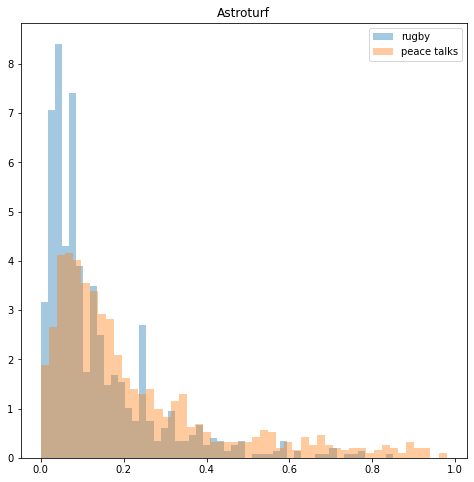

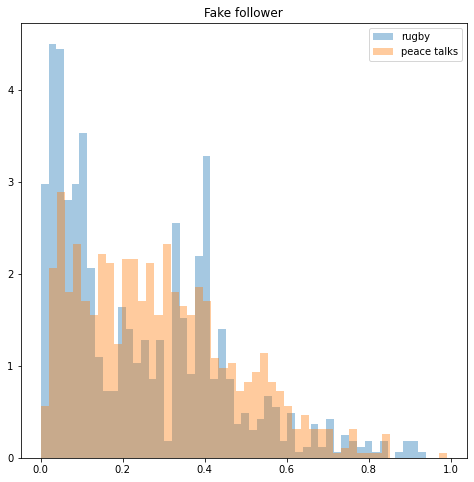

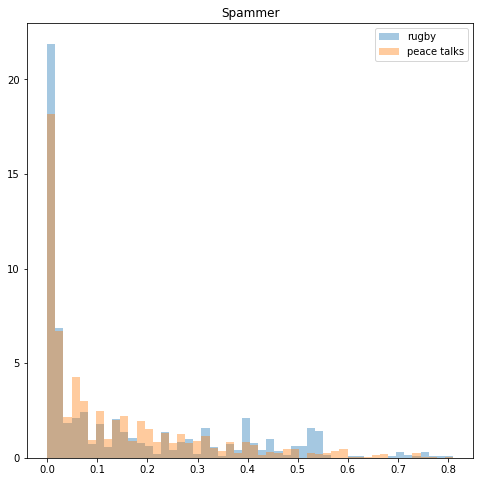

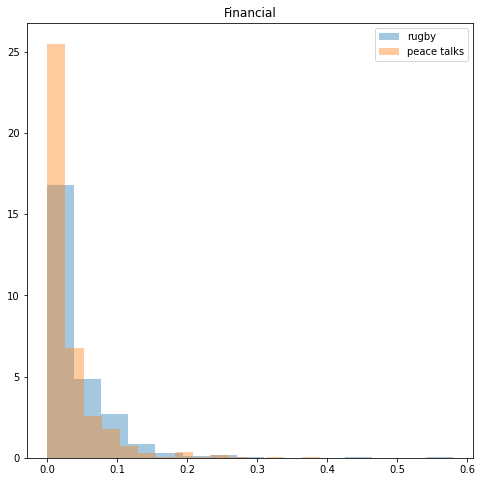

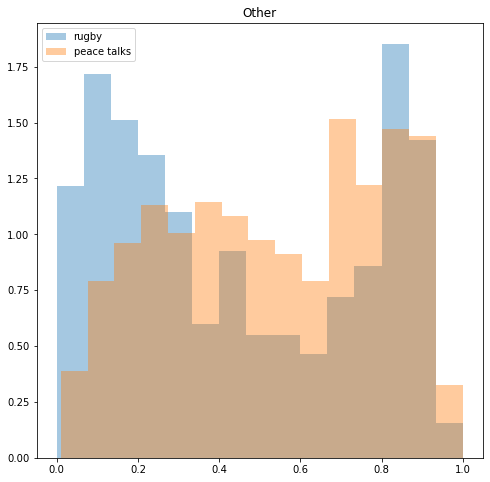

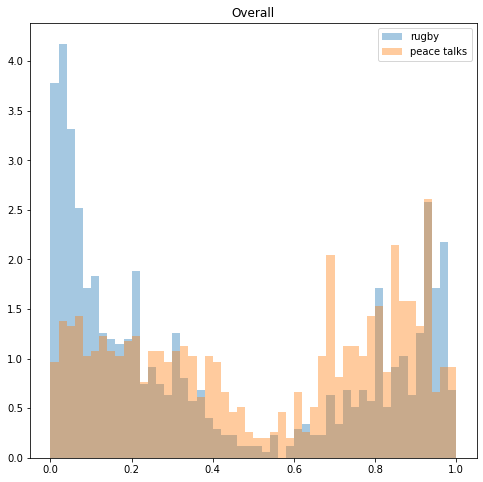

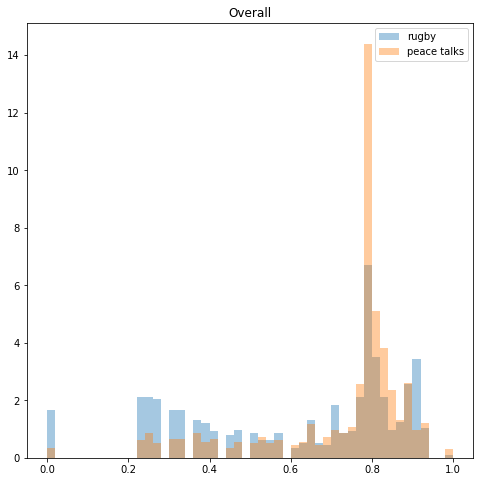

In [13]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_astroturf_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_astroturf_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.title('Astroturf')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_fake_follower_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_fake_follower_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.title('Fake follower')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_spammer_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_spammer_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.title('Spammer')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_financial_rugby, 15, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_financial_peace, 15, alpha = 0.4, label = 'peace talks', density = True)
plt.title('Financial')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_other_rugby, 15, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_other_peace, 15, alpha = 0.4, label = 'peace talks', density = True)
plt.title('Other')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_overall_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_overall_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.title('Overall')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_cap_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_cap_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.title('Overall')
plt.legend()


### Finding who is the most botlike:

In [18]:
score_overall_rugby[np.where(score_overall_rugby > 0.75)[0]]

0      0.82
3      0.91
5      0.82
6      0.92
14     0.95
       ... 
853    0.84
866    1.00
867    0.91
871    0.85
872    0.97
Name: Overall, Length: 253, dtype: float64

In [13]:
tweets_en_df_rugby.loc[np.where((score_overall_rugby > 0.75))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
0    0           2022-03-18 23:47:02+00:00  1504967648064552962   
3    3           2022-03-18 23:26:16+00:00  1504962419042385920   
5    5           2022-03-18 23:06:33+00:00  1504957459349258247   
6    6           2022-03-18 23:06:03+00:00  1504957334073790469   
14   14          2022-03-18 20:03:06+00:00  1504911290833117184   
15   15          2022-03-18 20:03:03+00:00  1504911279642738689   
16   16          2022-03-18 20:03:00+00:00  1504911266703310849   
17   17          2022-03-18 20:02:57+00:00  1504911255651307521   
18   18          2022-03-18 20:02:54+00:00  1504911243173195776   
19   19          2022-03-18 20:02:51+00:00  1504911230032494593   
20   20          2022-03-18 20:02:48+00:00  1504911217168564224   
21   21          2022-03-18 20:02:46+00:00  1504911206229848064   
22   22          2022-03-18 20:02:43+00:00  1504911194431188993   
23   23          2022-03-18 20:02:40+00:00  1504911181902802944   
24   24          2022-03-18 20:02:37+00:00  1504911170204930050   
25   25          2022-03-18 20:02:34+00:00  1504911158049841152   
26   26          2022-03-18 20:02:32+00:00  1504911149925638146   
27   27          2022-03-18 20:02:32+00:00  1504911147660623872   
28   28          2022-03-18 20:02:31+00:00  1504911146016419844   
29   29          2022-03-18 20:02:31+00:00  1504911143265050628   
30   30          2022-03-18 20:02:30+00:00  1504911139477594114   
31   31          2022-03-18 20:02:24+00:00  1504911116803092481   
32   32          2022-03-18 20:02:23+00:00  1504911113426776072   
33   33          2022-03-18 20:02:22+00:00  1504911108540358661   
34   34          2022-03-18 20:02:21+00:00  1504911104597712904   
35   35          2022-03-18 20:02:20+00:00  1504911097350041602   
36   36          2022-03-18 20:02:19+00:00  1504911093839314947   
47   47          2022-03-18 18:44:27+00:00  1504891498172665856   
53   53          2022-03-18 17:44:28+00:00  1504876402805551108   
64   64          2022-03-18 15:16:39+00:00  1504839204810985475   
75   75          2022-03-18 14:00:45+00:00  1504820102566395905   
78   78          2022-03-18 13:36:01+00:00  1504813879460872192   
94   94          2022-03-18 09:25:34+00:00  1504750850757087242   
102  102         2022-03-18 08:23:49+00:00  1504735310084820995   
111  111         2022-03-18 07:16:22+00:00  1504718337280032770   
112  112         2022-03-18 07:16:21+00:00  1504718333467320330   
113  113         2022-03-18 07:16:20+00:00  1504718330233597952   
114  114         2022-03-18 07:16:19+00:00  1504718323669426193   
115  115         2022-03-18 07:16:18+00:00  1504718322222391301   
116  116         2022-03-18 07:05:05+00:00  1504715499183423490   
121  121         2022-03-18 02:02:48+00:00  1504639427288698881   
122  122         2022-03-18 02:02:47+00:00  1504639420158427138   
123  123         2022-03-18 02:02:45+00:00  1504639412801617922   
124  124         2022-03-18 02:02:43+00:00  1504639405100871695   
125  125         2022-03-18 02:02:41+00:00  1504639396238307328   
126  126         2022-03-18 02:02:39+00:00  1504639386893365251   
127  127         2022-03-18 02:02:37+00:00  1504639378974457856   
128  128         2022-03-18 02:02:36+00:00  1504639372892725252   
129  129         2022-03-18 02:02:35+00:00  1504639371701628952   
130  130         2022-03-18 02:02:33+00:00  1504639364047024136   
131  131         2022-03-18 02:02:32+00:00  1504639356165926924   
132  132         2022-03-18 02:02:30+00:00  1504639348653928469   
133  133         2022-03-18 02:02:28+00:00  1504639341259370515   
134  134         2022-03-18 02:02:26+00:00  1504639333025951784   
135  135         2022-03-18 02:02:26+00:00  1504639330974937095   
136  136         2022-03-18 02:02:25+00:00  1504639328206696453   
137  137         2022-03-18 02:02:24+00:00  1504639324788191232   
138  138         2022-03-18 02:02:22+00:00  1504639318215860232   
139  139         2022-03-18 02:02:21+00:00  15046393

In [25]:
tweets_en_df_rugby.loc[np.where((score_overall_rugby > 0.75) & (score_self_declared_rugby < 0.6))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
47   47          2022-03-18 18:44:27+00:00  1504891498172665856   
53   53          2022-03-18 17:44:28+00:00  1504876402805551108   
75   75          2022-03-18 14:00:45+00:00  1504820102566395905   
78   78          2022-03-18 13:36:01+00:00  1504813879460872192   
102  102         2022-03-18 08:23:49+00:00  1504735310084820995   
157  157         2022-03-19 23:44:41+00:00  1505329444306759681   
177  177         2022-03-19 22:55:08+00:00  1505316971294126081   
212  212         2022-03-19 22:22:36+00:00  1505308786952708101   
226  226         2022-03-19 22:14:44+00:00  1505306805529944066   
253  253         2022-03-19 22:06:05+00:00  1505304630393196552   
283  283         2022-03-19 21:59:28+00:00  1505302964059082752   
292  292         2022-03-19 21:57:16+00:00  1505302412478894100   
307  307         2022-03-19 21:54:17+00:00  1505301657948758022   
342  342         2022-03-19 21:50:36+00:00  1505300734509830145   
349  349         2022-03-19 21:50:01+00:00  1505300585104519177   
357  357         2022-03-19 21:48:42+00:00  1505300255956475908   
363  363         2022-03-19 21:46:17+00:00  1505299644837994503   
392  392         2022-03-19 21:26:47+00:00  1505294740580929547   
407  407         2022-03-19 21:16:09+00:00  1505292061511241729   
412  412         2022-03-19 21:12:33+00:00  1505291157496074249   
419  419         2022-03-19 21:03:48+00:00  1505288954219839498   
433  433         2022-03-19 20:57:34+00:00  1505287387966025731   
446  446         2022-03-19 20:52:28+00:00  1505286103330435072   
478  478         2022-03-19 20:40:15+00:00  1505283027450142723   
534  534         2022-03-19 20:06:17+00:00  1505274478925910019   
552  552         2022-03-19 19:58:00+00:00  1505272398173593614   
637  637         2022-03-19 18:43:23+00:00  1505253617154019331   
781  781         2022-03-20 07:11:06+00:00  1505441787439030273   
790  790         2022-03-20 05:50:36+00:00  1505421529122852866   
797  797         2022-03-20 03:59:14+00:00  1505393503395713027   

                                                                                                                                                                                                                                                                                                                      Text  \
47   France v England predictions and rugby union tips: Crunch time for Les Bleus - Racing Post https://t.co/V7V39E0Aj9                                                                                                                                                                                                      
53   France v England predictions and rugby union tips: Crunch time for Les Bleus - Racing Post https://t.co/Z7o6KxMO9b                                                                                                                                                                                                      
75   @SixNationsRugby Most likely. I guarantee if England beat France, Ireland will slip up against Scotland and they’ll win it anyway. Much as I love Ireland, it’s not likely they’ll take it                                                                                                                              
78   @SixNationsRugby @EnglandRugby @FranceRugby The Premiership teams provide a landslide of tries ever weekend, exciting attacking play, skilful players and Eddie Jones’s team cannot buy a try. Go figure! What’s the betting that after England lose to France that Fast Eddie blames the Premiership structure etc..   
102  Preview: France v England via @SixNationsRugby https://t.co/iWLaYmoLIF                                                                                                                                                                                                                                                  
157  Rugby-Superb F

In [26]:
tweets_en_df_peace.loc[np.where((score_overall_peace > 0.75) & (score_self_declared_peace < 0.6))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
11   11          2022-03-27 23:08:53+00:00  1508219534611730435   
19   19          2022-03-27 22:41:13+00:00  1508212574374047751   
20   20          2022-03-27 22:39:53+00:00  1508212240171905028   
41   41          2022-03-27 22:09:00+00:00  1508204465102499851   
42   42          2022-03-27 22:08:53+00:00  1508204437088747529   
48   48          2022-03-27 22:03:10+00:00  1508202998194974724   
50   50          2022-03-27 22:00:21+00:00  1508202290720694277   
51   51          2022-03-27 21:59:58+00:00  1508202194738290688   
69   69          2022-03-27 21:17:11+00:00  1508191425598349312   
88   88          2022-03-27 20:45:27+00:00  1508183442294419459   
96   96          2022-03-27 20:26:17+00:00  1508178616760377348   
139  139         2022-03-27 19:11:24+00:00  1508159770070601728   
214  214         2022-03-27 16:52:03+00:00  1508124705106001926   
223  223         2022-03-27 16:38:50+00:00  1508121379064930304   
224  224         2022-03-27 16:38:25+00:00  1508121271984349197   
237  237         2022-03-27 16:12:05+00:00  1508114644241690625   
254  254         2022-03-27 15:44:36+00:00  1508107730258640899   
256  256         2022-03-27 15:42:20+00:00  1508107156704403457   
257  257         2022-03-27 15:38:19+00:00  1508106149681319945   
281  281         2022-03-27 14:55:35+00:00  1508095391451041796   
283  283         2022-03-27 14:52:13+00:00  1508094546932113416   
292  292         2022-03-27 14:35:03+00:00  1508090226090020865   
295  295         2022-03-27 14:29:57+00:00  1508088942406639620   
315  315         2022-03-27 13:50:06+00:00  1508078914807209985   
316  316         2022-03-27 13:47:01+00:00  1508078136847593475   
323  323         2022-03-27 13:18:34+00:00  1508070976457687041   
340  340         2022-03-27 12:47:35+00:00  1508063179787714560   
341  341         2022-03-27 12:46:24+00:00  1508062884345139210   
346  346         2022-03-27 12:31:20+00:00  1508059092383903745   
354  354         2022-03-27 12:01:09+00:00  1508051495811379200   
355  355         2022-03-27 12:00:06+00:00  1508051230496419840   
356  356         2022-03-27 12:00:03+00:00  1508051219113132034   
359  359         2022-03-27 11:58:05+00:00  1508050723522576384   
365  365         2022-03-27 11:47:02+00:00  1508047943869284354   
372  372         2022-03-27 10:42:11+00:00  1508031623857647619   
408  408         2022-03-27 07:04:30+00:00  1507976842388688900   
433  433         2022-03-27 05:01:36+00:00  1507945912303484929   
435  435         2022-03-27 04:54:25+00:00  1507944105216995337   
446  446         2022-03-27 03:21:59+00:00  1507920842679734285   
451  451         2022-03-27 03:00:52+00:00  1507915527456530437   
452  452         2022-03-27 03:00:01+00:00  1507915313454940161   
457  457         2022-03-27 02:47:12+00:00  1507912088852877317   
476  476         2022-03-27 00:38:33+00:00  1507879714400063490   
492  492         2022-03-28 23:45:00+00:00  1508591012297412609   
528  528         2022-03-28 23:20:54+00:00  1508584946297974786   
537  537         2022-03-28 23:17:19+00:00  1508584045776715786   
538  538         2022-03-28 23:17:04+00:00  1508583983499689990   
541  541         2022-03-28 23:16:12+00:00  1508583765576060930   
546  546         2022-03-28 23:11:29+00:00  1508582577245937666   
548  548         2022-03-28 23:09:06+00:00  1508581978232160256   
549  549         2022-03-28 23:08:55+00:00  1508581933499965447   
551  551         2022-03-28 23:06:03+00:00  1508581212792799232   
573  573         2022-03-28 22:48:25+00:00  1508576774409662472   
575  575         2022-03-28 22:47:04+00:00  1508576434876399617   
580  580         2022-03-28 22:40:14+00:00  1508574715283185664   
614  614         2022-03-28 22:13:47+00:00  1508568056758374406   
616  616         2022-03-28 22:12:07+00:00  1508567638657613825   
638  638         2022-03-28 22:00:08+00:00  1508564621233639424   
641  641         2022-03-28 21:57:38+00:00  15085639

In [11]:
tweets_en_df_rugby.loc[np.where((score_overall_rugby > 0.75) & (score_self_declared_rugby < 0.6) & (score_other_rugby < 0.6))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
307  307         2022-03-19 21:54:17+00:00  1505301657948758022   
357  357         2022-03-19 21:48:42+00:00  1505300255956475908   
392  392         2022-03-19 21:26:47+00:00  1505294740580929547   
419  419         2022-03-19 21:03:48+00:00  1505288954219839498   

                                                                                                                                                                                                                                                 Text  \
307  79 min\n\nFrance deservedly about to win the Grand Slam\n\nWhat are the commentator's final thoughts?\n\n"What do we think England can take from this game?"\n\nFFS! 🤔\n\nBest team in the 6 Nations.\n\nCongratulations @FranceRugby\n #FRAvENG   
357  @UTDJack10 @FranceRugby I totally agree though. England are pretty shit at the moment                                                                                                                                                              
392  @FranceRugby England fan here, it's a joy to watch this french team                                                                                                                                                                                
419  @ScotsmanPaddy The commentary sums up just why I dislike having to view the rugby on ITV. France playing England off the park and all the pundits comments are o me miserum.                                                                       

          Username  Like Count             Display Name Language  Astroturf  \
307  MikeFealey     1           Mike Fealey #JohnsonOut  en       0.85        
357  Digby_sdb      0           Sam Bolton               en       0.06        
392  Digby_sdb      11          Sam Bolton               en       0.06        
419  markrowantree  2           markrowantree            en       0.77        

     Fake follower  Financial  Other  Overall  Self declared  Spammer  \
307  0.22           0.10       0.41   0.85     0.02           0.02      
357  0.78           0.24       0.53   0.78     0.56           0.54      
392  0.78           0.24       0.53   0.78     0.56           0.54      
419  0.16           0.03       0.37   0.77     0.03           0.01      

          Cap  
307  0.833918  
357  0.807604  
392  0.807604  
419  0.805478

In [12]:
tweets_en_df_peace.loc[np.where((score_overall_peace > 0.75) & (score_self_declared_peace < 0.6) & (score_other_peace < 0.6))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
11   11          2022-03-27 23:08:53+00:00  1508219534611730435   
19   19          2022-03-27 22:41:13+00:00  1508212574374047751   
42   42          2022-03-27 22:08:53+00:00  1508204437088747529   
88   88          2022-03-27 20:45:27+00:00  1508183442294419459   
139  139         2022-03-27 19:11:24+00:00  1508159770070601728   
223  223         2022-03-27 16:38:50+00:00  1508121379064930304   
224  224         2022-03-27 16:38:25+00:00  1508121271984349197   
237  237         2022-03-27 16:12:05+00:00  1508114644241690625   
254  254         2022-03-27 15:44:36+00:00  1508107730258640899   
256  256         2022-03-27 15:42:20+00:00  1508107156704403457   
283  283         2022-03-27 14:52:13+00:00  1508094546932113416   
292  292         2022-03-27 14:35:03+00:00  1508090226090020865   
295  295         2022-03-27 14:29:57+00:00  1508088942406639620   
315  315         2022-03-27 13:50:06+00:00  1508078914807209985   
323  323         2022-03-27 13:18:34+00:00  1508070976457687041   
340  340         2022-03-27 12:47:35+00:00  1508063179787714560   
341  341         2022-03-27 12:46:24+00:00  1508062884345139210   
346  346         2022-03-27 12:31:20+00:00  1508059092383903745   
446  446         2022-03-27 03:21:59+00:00  1507920842679734285   
451  451         2022-03-27 03:00:52+00:00  1507915527456530437   
538  538         2022-03-28 23:17:04+00:00  1508583983499689990   
541  541         2022-03-28 23:16:12+00:00  1508583765576060930   
551  551         2022-03-28 23:06:03+00:00  1508581212792799232   
706  706         2022-03-28 21:18:21+00:00  1508554109124763658   
786  786         2022-03-28 20:43:46+00:00  1508545402504728586   
810  810         2022-03-28 20:28:47+00:00  1508541633997901826   
830  830         2022-03-28 20:16:15+00:00  1508538477595529220   
892  892         2022-03-28 19:50:46+00:00  1508532068002713607   
927  927         2022-03-28 19:33:37+00:00  1508527751103406089   
946  946         2022-03-28 19:22:39+00:00  1508524991108640771   
955  955         2022-03-28 19:17:31+00:00  1508523697832964096   

                                                                                                                                                                                                                                                                                                            Text  \
11   Trump Wouldn't Be 'Capable' Of Ukraine Peace Talks With Moscow, Says John Bolton\nhttps://t.co/pp1bB0ij4E                                                                                                                                                                                                     
19   Current reporting, "Russia and Ukraine will hold another round of in-person peace talks in Turkey starting tomorrow, the head of Kyiv’s delegation says". https://t.co/PS1qXam8wa                                                                                                                             
42   Trump Wouldn’t Be ‘Capable’ Of Ukraine Peace Talks With Moscow, Says John Bolton\nhttps://t.co/sGqHNK2y5E                                                                                                                                                                                                     
88   Russia-Ukraine live updates: Agreement reached on new round of in-person peace talks - ABC News - https://t.co/hWCvyCBrf0 via @ABC                                                                                                                                                                            
139  Lets see, as one of the elitist DC "Smart ppl", I'm sure you realize #Puntin invaded #Ukraine under Obama &amp; #JoeBiden -NOT #Trump ... would not be 'capable' of holding Ukraine-Russia peace talks, says his former national security adviser John Bolton https://t.co/5yrMuN508E                         
223  Trump W